In [1]:
import matplotlib.pylab as plt
import numpy as np
from torchvision.io import read_image
import urllib.request
from PIL import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from absl import logging
logging.set_verbosity(logging.INFO)

import utils
import runner

/home/ubuntu/anaconda3/envs/uio-inf/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# uio = runner.ModelRunner("base", "base.bin")
# uio = runner.ModelRunner("large", "large.bin")
uio = runner.ModelRunner("xl", "xl.bin")

INFO:absl:Setting up model...
INFO:absl:Loading parameters...
INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:absl:Model is ready


In [21]:
import matplotlib.patches as patches


def show_images(images, nrow=3, scale=6):
    if len(images.shape) == 4 and images.shape[0] == 1:
        images = images[0]
    if len(images.shape) == 3:
        fig, ax = plt.subplots()
        ax.set_xticklabels([])
        ax.set_yticklabels([])    
        ax.imshow(images)
        plt.show()
    else:
        n = images.shape[0]
        ncol = (n + nrow - 1) // nrow
        if ncol == 1:
            nrow = min(nrow, n)
        fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True, figsize=(scale*nrow, scale*ncol))
        if ncol > 1:
            axes = [item for rows in axes for item in rows]
        i = 0
        for ax, im in zip(axes, images):
            ax.imshow(im)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        fig.subplots_adjust(wspace=0, hspace=0)
        fig.show()

def show_location(input_image, boxes, labels=None):
    fig, ax = plt.subplots()
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i].tolist()
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')
        if labels is not None:
            plt.text(x1, y1, labels[i], color='r')
        ax.add_patch(rect)
    
    ax.imshow(input_image)
    plt.show()
    
    
def show_pose(boxes, labels, image):
    fig, ax = plt.subplots()
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    for x1, y1 in boxes[labels > 0]:
        rect = patches.Rectangle((x1, y1), 4, 4, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)    
    ax.imshow(image)
    plt.show()
    


def load_image_from_url(url):
    with urllib.request.urlopen(url) as f:
        img = Image.open(f)
        return np.array(img)

In [6]:
hotel_img = load_image_from_url('https://farm2.staticflickr.com/1362/1261465554_95741e918b_z.jpg')
tennis_img = load_image_from_url('https://farm9.staticflickr.com/8313/7954229658_03f8e8d855_z.jpg')
penguin_img = load_image_from_url('https://i.stack.imgur.com/z9vLx.jpg')

In [7]:
uio.caption(hotel_img)["text"]

INFO:absl:Running model text_inputs=['What does the image describe ?']


'a hotel room with a bed and a couch in it.'

In [8]:
uio.vqa(hotel_img, "what color is the couch?")["text"]

INFO:absl:Running model text_inputs=['what color is the couch?']


'green.'

In [28]:
# Image classification support a list of answer options to support different category sets
out = uio.image_classification(hotel_img, answer_options=["hotel room", "pool", "bedroom"])
out

INFO:absl:Running model text_inputs=['What is this in the image ?'] and 3 answer options


{'text': 'hotel room', 'score': array([5.67282], dtype=float32)}

Input location:


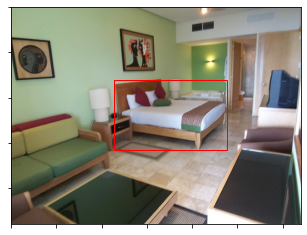

INFO:absl:Running model text_inputs=['What is the category of region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> " ?'] and 3 answer options


'bed'

In [34]:
box = [226.56, 160.64, 476.16, 316.16]
print("Input location:")
show_location(hotel_img, np.array([box]))
out = uio.region_classification(hotel_img, box, answer_options=["bed", "chair", "sofa"])
out["text"]

INFO:absl:Running model text_inputs=['What is the depth map of the image ?']


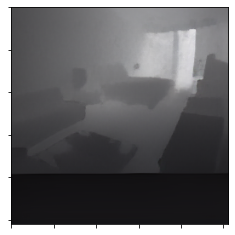

In [10]:
out = uio.depth(hotel_img, num_decodes=None)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the surface normal of the image ?']


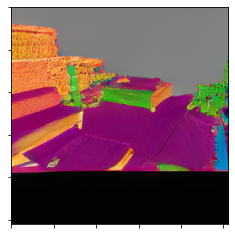

In [11]:
out = uio.surface_normal(hotel_img)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the complete image? Text: " A horse in a grassy field. " .']


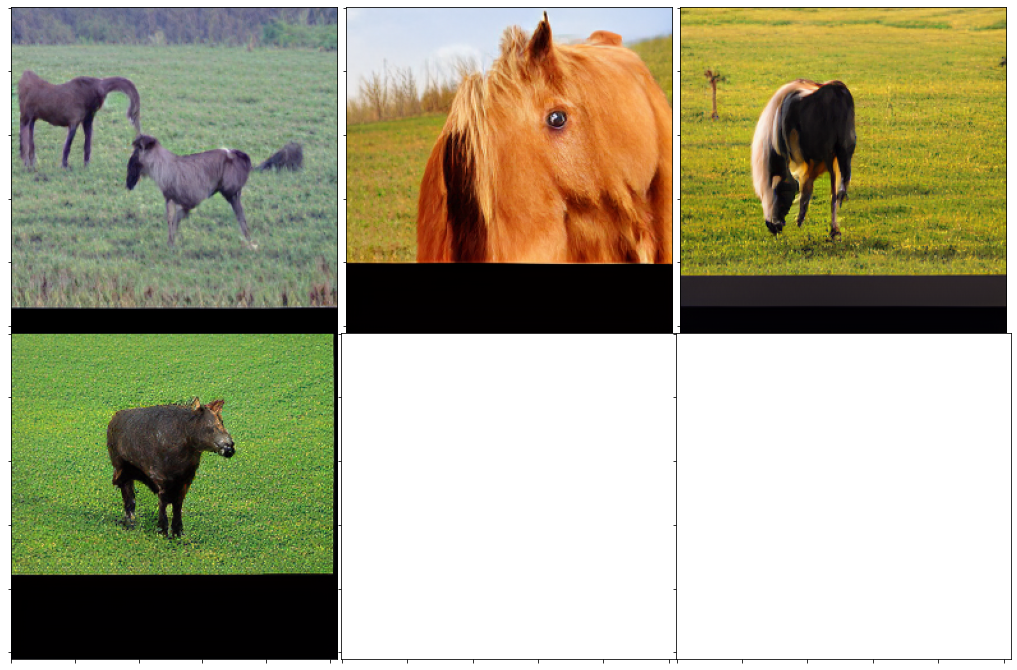

In [12]:
out = uio.image_generation("A horse in a grassy field.", num_decodes=4)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the segmentation of " painting " ?']


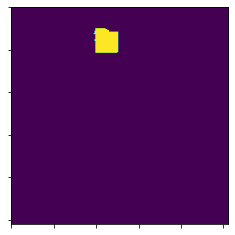

In [13]:
out = uio.object_segmentation(hotel_img, "painting")
# show_images(out["image"])
# print(out["mask"])
# mask will be a list of binary masks, on for each instance
show_images(np.expand_dims(np.stack(out["mask"]), -1))

INFO:absl:Running model text_inputs=['Which region does the text " bed " describe ?']


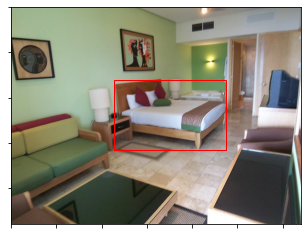

In [16]:
out = uio.refexp(hotel_img, "bed")
show_location(hotel_img, out["boxes"])

In [18]:
out = uio.region_caption(hotel_img, box)
out["text"]

INFO:absl:Running model text_inputs=['What does the region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> " describe ?']


'a bed with a white sheet'

INFO:absl:Running model text_inputs=['Find the human joints in the region " <extra_id_274> <extra_id_101> <extra_id_931> <extra_id_515> " .']


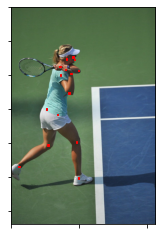

In [22]:
box = [1, 112, 266, 533]
out = uio.pose(tennis_img, box)
show_pose(out["points"], out['labels'], tennis_img)

INFO:absl:Running model text_inputs=['Filling the blank region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> table " ?']


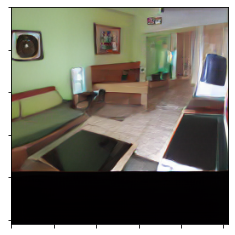

In [23]:
box = [226.56, 160.64, 476.16, 316.16]
out = uio.image_inpainting(hotel_img, box, "table", 1)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the complete image? Segmentation color: " penguin : white "']


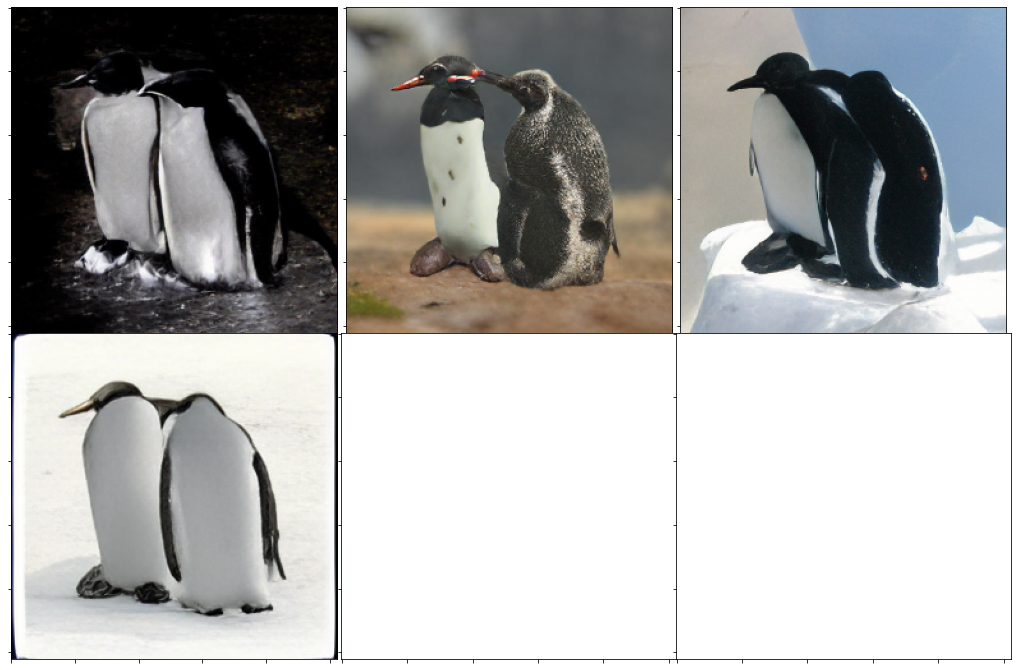

In [24]:
# image = read_image('dbg_penguin_outline.jpg').numpy().transpose(1, 2, 0)
out = uio.segmentation_based_generation([penguin_img[:, :, 0] > 10], ["penguin"], num_decodes=4)
show_images(out["image"])